# Google Landmark Recognition Challenge

In [2]:
import pandas as pd
import numpy as np
import cv2
import sys
import requests
import shutil
import os
import zipfile
import time
from glob import glob
from urllib import request, error
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from sklearn.datasets import load_files  
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from keras.utils import np_utils, plot_model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint  
from keras.models import Sequential, Model, load_model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Flatten, Dense, Input, BatchNormalization, Add, concatenate              
from keras import optimizers
from keras.applications.resnet50 import ResNet50
from keras.layers.advanced_activations import LeakyReLU

In [3]:
def ReadData(file):
    with zipfile.ZipFile("GLRC/"+file+".zip","r") as z:                   #unzips files to make readable
        z.extractall(".")
    data = pd.read_csv(file, nrows=5000)
    Id = data['id']
    url = data['url']
    if 'landmark_id' in data.columns:
        lndmrk = data['landmark_id']
    else:
        lndmrk = None
    return data, Id, url, lndmrk

def ImageCreation(files,images,lndmrks):
    identifier = 0
    max_identifier = len(files)
    img_size = (250,250)
    while identifier < max_identifier:
        path = 'GLRC/TRAINING/' + str(lndmrks[identifier]) + '/' + str(files[identifier]) + '.jpg'
        folder = 'GLRC/TRAINING/' + str(lndmrks[identifier])
        if not os.path.exists(path):
            if not os.path.exists(folder):
                os.makedirs(folder)
            try:
                response = requests.get(images[identifier], stream=True)
                with open(path, 'wb') as destination:
                    shutil.copyfileobj(response.raw, destination)
                    img = Image.open(path)
                    img = img.resize(img_size, Image.ANTIALIAS)
                    img = img.convert('RGB')
                    img.save(path, 'JPEG')
                    identifier += 1
            except:
                os.remove(path)         
                identifier += 1  
               
        identifier += 1
            
def TestImageCreation(files,images):
    identifier = 0
    max_identifier = len(files)
    img_size = 250,250
    while identifier < max_identifier:
        path = 'GLRC/TESTING/' + str(files[identifier]) + '.jpg'
        if not os.path.exists(path):
            if not os.path.exists('GLRC/TESTING'):
                os.makedirs('GLRC/TESTING')
            try:
                response = requests.get(images[identifier], stream=True)
                with open(path, 'wb') as destination:
                    shutil.copyfileobj(response.raw, destination)
                    img = Image.open(path)
                    img = img.resize(img_size, Image.ANTIALIAS)
                    img = img.convert('RGB')
                    img.save(path, 'JPEG')
                    identifier += 1
            except:
                os.remove(path) 
                identifier += 1   
        identifier += 1
            
train_data, train_files, train_image, train_landmark = ReadData('train.csv')
test_data, test_files, test_image, test_landmark = ReadData('test.csv')

In [57]:
ImageCreation(train_files,train_image,train_landmark)
TestImageCreation(test_files,test_image)

/usr/local/lib/python3.5/dist-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


In [58]:
print (len(train_files))
print (len(np.unique(train_landmark)))

5000
2286


In [2]:
def file_count(path, map = {}):
  count = 0
  for f in os.listdir(path):
    child = os.path.join(path, f)
    if os.path.isdir(child):
      child_count = file_count(child, map)
      count += child_count + 1 # unless include self
  map[path] = count
  return count

path = "GLRC/TRAINING"
map = {}
print (file_count(path, map))

2274


In [3]:
def empty_files(path):
    count = 0
    for f in os.listdir(path):
        child = os.path.join(path, f)
        if os.path.isdir(child):
            if os.listdir(child) == []:
                count += 1
                print (child)
    print (count)

empty_files('GLRC/TRAINING')
    
def del_empty_lndmrk(path):
    for f in os.listdir(path):
        child = os.path.join(path, f)
        if os.path.isdir(child):
            if os.listdir(child) == []:
                os.rmdir(child)

del_empty_lndmrk('GLRC/TRAINING')

def empty_files(path):
    count = 0
    for f in os.listdir(path):
        child = os.path.join(path, f)
        if os.path.isdir(child):
            if os.listdir(child) == []:
                count += 1
                print (child)
    print (count)

empty_files('GLRC/TRAINING')

0
0


In [4]:
def file_count(path, map = {}):
  count = 0
  for f in os.listdir(path):
    child = os.path.join(path, f)
    if os.path.isdir(child):
      child_count = file_count(child, map)
      count += child_count + 1 # unless include self
  map[path] = count
  return count

path = "GLRC/TRAINING"
map = {}
print (file_count(path, map))

2274


In [4]:
LANDMARKS = [item[14:-1] for item in sorted(glob("GLRC/TRAINING/*/"))]

In [4]:
def load_dataset(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    target = np.array(data['target'])
    lndmrk_target = list(np.array(data['target']))
    unique_target = len(np.unique(data['target']))
    print ('Max targets: ' + str(unique_target))
    print ('Total targets: ' + str(len(target)))
    print ('Unique Targets: ' + str(unique_target))
    targets = np_utils.to_categorical(target, unique_target)
    
    return files, targets, unique_target, lndmrk_target

train_files, train_targets, unique_targets, landmark_targets = load_dataset('GLRC/TRAINING')

Max targets: 2274
Total targets: 4967
Unique Targets: 2274


In [5]:
train_files, valid_files, train_targets, valid_targets = train_test_split(train_files, train_targets,
                                                                          test_size=0.3, random_state=31)

valid_files, testingV_files, valid_targets, testingV_targets = train_test_split(valid_files, valid_targets,
                                                                               test_size=0.5, random_state=80)

In [6]:
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(250, 250))
    # convert PIL.Image.Image type to 3D tensor with shape (250, 250, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 250, 250, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [7]:
# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
Vtest_tensors = paths_to_tensor(testingV_files).astype('float32')/255

100%|███████████████████████████████████████████████████████████████████████████████| 746/746 [00:04<00:00, 168.35it/s]


In [9]:
print (train_tensors.shape)
print (valid_tensors.shape)
print (Vtest_tensors.shape)

(3476, 250, 250, 3)
(745, 250, 250, 3)
(746, 250, 250, 3)


In [10]:
print (train_targets.shape)

(3476, 2274)


# CNN Architecture (Res-Incep vs ResNet-50)

In [10]:
def residual_network(input_tensor):
    """
    Model uses residual learning in conjunction with Inception blocks to increase network depth and training while minimizing
    the overall parameters used
    """
    def normalization_layers(y):
        y = BatchNormalization()(y)
        y = LeakyReLU()(y)

        return y

    def resid_block(y, filters, output, stride=(1, 1), resid_jump=False):
        """
        The network consists of a stack of residual blocks with inception networks builtin. The topology is the same, the filter size
        and strides are the same unless downsizing
        """
        shortcut = y

        y = incep_network(y, filters, stride)
        y = normalization_layers(y)
        y = Conv2D(output, kernel_size=(1, 1), strides=(1, 1), padding='same')(y)
        y = BatchNormalization()(y)
        if resid_jump or stride != (1, 1):
            # when the dimensions increase, shortcut is used to match dimensions
            # when the shortcuts go across feature maps of two sizes, they are performed with a stride of 2
            shortcut = Conv2D(output, kernel_size=(1, 1), strides=stride, padding='same')(shortcut)
            shortcut = BatchNormalization()(shortcut)

        y = Add()([shortcut, y])

        return y

    def incep_network(y, filters, stride):
        '''
        Inception block has 4 convolutional layered towers containing 1x1, 3x3, 5x5, and MaxPool filters. Each layer
        is merged within a concatentation layer to produce one output.
        '''
# Conv-Tower 1
        y1 = Conv2D(filters, (1,1), padding='same', activation='relu')(y)
        y1 = Conv2D(filters, (3,3), padding='same', activation='relu')(y1)
        y1 = Conv2D(filters, (1,1), padding='same', activation='relu')(y1)
# Conv-Tower 2
        y2 = Conv2D(filters, (1,1), padding='same', activation='relu')(y)
        y2 = Conv2D(filters, (5,5), padding='same', activation='relu')(y2)
        y2 = Conv2D(filters, (1,1), padding='same', activation='relu')(y2)
# Conv-Tower 3
        y3 = MaxPooling2D((2,2), strides=(1,1), padding='same')(y)
        y3 = Conv2D(filters, (1,1), padding='same', activation='relu')(y3)
# Conv-Tower 4
        y4 = Conv2D(filters, (1,1), padding='same', activation='relu')(y)

        concat  = concatenate([y1, y2, y3, y4])
        y = MaxPooling2D((2,2), strides=stride, padding='same')(concat)

        return y

# Conv-Layer 1
    x = Conv2D(35, kernel_size=(5,5), strides=(1,1), padding='same')(input_tensor)
    x = normalization_layers(x)
# ConvIncep-Layer 2
    x = resid_block(x, filters=40, output=60, stride=(1,1), resid_jump=True)
    x = normalization_layers(x)
# ConvIncep-Layer 3
    for count in range(2):
        filter = 60
        output = 75
        stride = (2, 2) if count == 0 else (1, 1)
        x = resid_block(x, filter, output, stride)
        x = normalization_layers(x)
# ConvIncep-Layer 4
    for count in range(2):
        filter = 75
        output = 80
        stride = (2, 2) if count == 0 else (1, 1)
        x = resid_block(x, filter, output, stride)
        x = normalization_layers(x)
# ConvIncep-Layer 5
    for count in range(2):
        filter = 80
        output = 100
        stride = (2, 2) if count == 0 else (1, 1)
        x = resid_block(x, filter, output, stride)
        x = normalization_layers(x)

    x = GlobalAveragePooling2D()(x)
    x = Dense(300,activation='relu',name='dense_one')(x)
    x = Dropout(0.2)(x)
    predict = Dense(unique_targets,activation='softmax',name='pred')(x)

    return predict

image_tensor = Input(shape = (250, 250, 3))
network_output = residual_network(image_tensor)

model = Model(inputs=[image_tensor], outputs=[network_output])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 250, 250, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 250, 250, 35) 2660        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 250, 250, 35) 140         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 250, 250, 35) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

batch_normalization_13 (BatchNo (None, 63, 63, 300)  1200        max_pooling2d_8[0][0]            
__________________________________________________________________________________________________
leaky_re_lu_8 (LeakyReLU)       (None, 63, 63, 300)  0           batch_normalization_13[0][0]     
__________________________________________________________________________________________________
conv2d_40 (Conv2D)              (None, 63, 63, 80)   6080        leaky_re_lu_7[0][0]              
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 63, 63, 80)   24080       leaky_re_lu_8[0][0]              
__________________________________________________________________________________________________
batch_normalization_15 (BatchNo (None, 63, 63, 80)   320         conv2d_40[0][0]                  
__________________________________________________________________________________________________
batch_norm

In [9]:
from keras.utils import plot_model
plot_model(model, to_file='Barrett_Arch.png')

In [ ]:
augdata = ImageDataGenerator(rotation_range=25,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             vertical_flip=True,
                             horizontal_flip=True,
                             zoom_range=0.2,
                             rescale=0.15)

augdata.fit(train_tensors)

In [9]:
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.95, nesterov=False)

model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

### RES-INCEP MODEL w/out AUGMENTATION DATA

In [48]:
epochs = 30

if not os.path.exists('GLRC/saved_models'):
    os.makedirs('GLRC/saved_models')
    
checkpointer = ModelCheckpoint(filepath='GLRC/saved_models/RESINCEP.weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

fitter = model.fit(train_tensors, train_targets, validation_data=(valid_tensors, valid_targets), 
                   epochs=epochs, batch_size=6, callbacks=[checkpointer])

Train on 3476 samples, validate on 745 samples
Epoch 1/30
3475/3476 [============================>.] - ETA: 0s - loss: 7.2227 - acc: 0.0452
Epoch 00001: val_loss improved from inf to 7.30044, saving model to GLRC/saved_models/RESINCEP.weights.best.from_scratch.hdf5
3476/3476 [==============================] - 1022s 294ms/step - loss: 7.2224 - acc: 0.0452 - val_loss: 7.3004 - val_acc: 0.0456
Epoch 2/30
3475/3476 [============================>.] - ETA: 0s - loss: 6.9425 - acc: 0.0512
Epoch 00002: val_loss did not improve
3476/3476 [==============================] - 1005s 289ms/step - loss: 6.9427 - acc: 0.0512 - val_loss: 7.3269 - val_acc: 0.0510
Epoch 3/30
3475/3476 [============================>.] - ETA: 0s - loss: 6.7658 - acc: 0.0547
Epoch 00003: val_loss did not improve
3476/3476 [==============================] - 1005s 289ms/step - loss: 6.7662 - acc: 0.0547 - val_loss: 7.3243 - val_acc: 0.0483
Epoch 4/30
3475/3476 [============================>.] - ETA: 0s - loss: 6.5697 - acc: 0.

In [14]:
model.load_weights('GLRC/saved_models/RESINCEP.weights.best.from_scratch.hdf5')

In [51]:
# get index of predicted dog breed for each image in test set
landmark_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in Vtest_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(landmark_predictions)==np.argmax(testingV_targets, axis=1))/len(landmark_predictions)
print('Original test accuracy: %.4f%%' % test_accuracy)

Original test accuracy: 5.8981%


In [49]:
model.save('GLRC/saved_models/Barrett.model.hdf5')

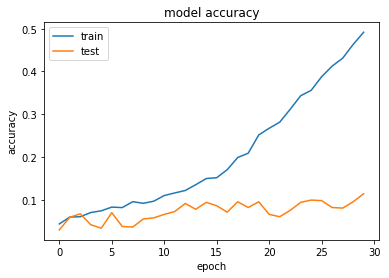

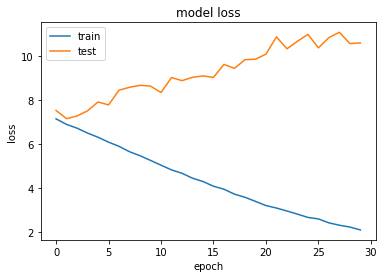

In [26]:
plt.plot(fitter.history['acc'])
plt.plot(fitter.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(fitter.history['loss'])
plt.plot(fitter.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### RES-INCEP MODEL with AUGMENTATION DATA

In [16]:
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.95, nesterov=True)

model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
epochs = 20
batch_size = 6

if not os.path.exists('GLRC/saved_models'):
    os.makedirs('GLRC/saved_models')
    
checkpointer = ModelCheckpoint(filepath='GLRC/saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit_generator(augdata.flow(train_tensors, train_targets, batch_size=batch_size),
                    steps_per_epoch=train_tensors.shape[0] // batch_size, 
                    epochs=epochs, callbacks=[checkpointer], verbose=1, 
                    validation_data=(valid_tensors, valid_targets))

Epoch 1/20
578/579 [============================>.] - ETA: 1s - loss: 7.2350 - acc: 0.0441
Epoch 00001: val_loss improved from inf to 15.23780, saving model to GLRC/saved_models/weights.best.from_scratch.hdf5
579/579 [==============================] - 983s 2s/step - loss: 7.2365 - acc: 0.0440 - val_loss: 15.2378 - val_acc: 0.0309
Epoch 2/20
578/579 [============================>.] - ETA: 1s - loss: 6.9718 - acc: 0.0482
Epoch 00002: val_loss did not improve
579/579 [==============================] - 967s 2s/step - loss: 6.9725 - acc: 0.0481 - val_loss: 15.5385 - val_acc: 0.0295
Epoch 3/20
578/579 [============================>.] - ETA: 1s - loss: 6.8041 - acc: 0.0522
Epoch 00003: val_loss did not improve
579/579 [==============================] - 967s 2s/step - loss: 6.8042 - acc: 0.0521 - val_loss: 15.7418 - val_acc: 0.0161
Epoch 4/20
578/579 [============================>.] - ETA: 1s - loss: 6.6306 - acc: 0.0606
Epoch 00004: val_loss did not improve
579/579 [==========================

In [18]:
model.load_weights('GLRC/saved_models/weights.best.from_scratch.hdf5')

In [19]:
# get index of predicted landmark for each image in test set
landmark_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in Vtest_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(landmark_predictions)==np.argmax(testingV_targets, axis=1))/len(landmark_predictions)
print('Original test accuracy with AUGMENTATION: %.4f%%' % test_accuracy)

Original test accuracy with AUGMENTATION: 4.5576%


## RESNET-50 Base Model

In [19]:
input_tensor = Input(shape=(250,250,3))

base_model = ResNet50(input_tensor=input_tensor, weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(unique_targets, activation='softmax')(x)

model1 = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
for layer in base_model.layers:
    layer.trainable = False

# creates a checkpointer weight filepath
if not os.path.exists('GLRC/saved_models'):
    os.makedirs('GLRC/saved_models')
    
checkpointer1 = ModelCheckpoint(filepath='GLRC/saved_models/ResNet50.weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model1.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
epochs = 35
batch_size = 55

fitter = model1.fit_generator(augdata.flow(train_tensors, train_targets, batch_size=batch_size),
                              steps_per_epoch=train_tensors.shape[0] // batch_size, 
                              epochs=epochs, callbacks=[checkpointer1], verbose=1, 
                              validation_data=(valid_tensors, valid_targets))


Epoch 1/35
62/63 [============================>.] - ETA: 0s - loss: 7.2997 - acc: 0.0648
Epoch 00001: val_loss improved from inf to 7.35511, saving model to GLRC/saved_models/ResNet50.weights.best.from_scratch.hdf5
63/63 [==============================] - 51s 816ms/step - loss: 7.3009 - acc: 0.0638 - val_loss: 7.3551 - val_acc: 0.0403
Epoch 2/35
62/63 [============================>.] - ETA: 0s - loss: 6.3583 - acc: 0.1141
Epoch 00002: val_loss did not improve
63/63 [==============================] - 43s 676ms/step - loss: 6.3642 - acc: 0.1134 - val_loss: 7.7903 - val_acc: 0.0201
Epoch 3/35
62/63 [============================>.] - ETA: 0s - loss: 5.8019 - acc: 0.1455
Epoch 00003: val_loss did not improve
63/63 [==============================] - 43s 677ms/step - loss: 5.7990 - acc: 0.1455 - val_loss: 9.0241 - val_acc: 0.0403
Epoch 4/35
62/63 [============================>.] - ETA: 0s - loss: 5.1121 - acc: 0.1780
Epoch 00004: val_loss did not improve
63/63 [==============================]

In [16]:
model1.load_weights('GLRC/saved_models/ResNet50.weights.best.from_scratch.hdf5')

In [15]:
# get index of predicted dog breed for each image in test set
landmark_predictions = [np.argmax(model1.predict(np.expand_dims(tensor, axis=0))) for tensor in Vtest_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(landmark_predictions)==np.argmax(testingV_targets, axis=1))/len(landmark_predictions)
print('ResNet50 model test accuracy: %.4f%%' % test_accuracy)

ResNet50 model test accuracy: 4.0214%


In [16]:
model1.save('GLRC/saved_models/ResNet50.model.hdf5')

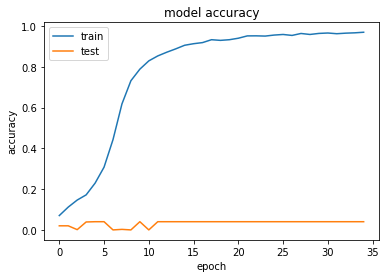

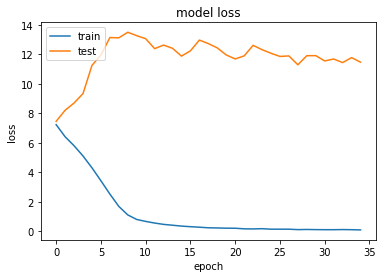

In [22]:
plt.plot(fitter.history['acc'])
plt.plot(fitter.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(fitter.history['loss'])
plt.plot(fitter.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Predict Image Landmark

In [96]:
def predict_landmark(img_path):
    start_time = time.time()
    test_tensor = path_to_tensor(img_path).astype('float32')/255
    
############# Comment out unwanted CNN model to run below #############

#    model = load_model('GLRC/saved_models/ResNet50.model.hdf5')
    model = load_model('GLRC/saved_models/Barrett.model.hdf5')
    
    prediction = model.predict(test_tensor)[0]
    landmark = LANDMARKS[np.argmax(prediction)]
    Id = img_path[13:-4]
    pred = max(prediction)
    accuracy = (pred / sum(prediction)) * 100
    if accuracy >= 2.50:
        print ('Image ID: ' + str(Id))
        print ('Landmark: ' + str(landmark) + ' -- Accuracy: {0:.3f}%'.format(accuracy))
        print ("--- %s seconds ---" % (time.time() - start_time))
        print ('------------------------------------------------------------------------')
    else: 
        print ('Image ' + str(Id) + ' does not contain any recognizable landmark')
        print ('--- %s seconds ---' % (time.time() - start_time))
        print ('------------------------------------------------------------------------')

        
predict_landmark('GLRC/TESTING/0006aea5b6f4eaaa.jpg')
predict_landmark('GLRC/TESTING/00273e8ac68611c6.jpg')
predict_landmark('GLRC/TESTING/01082d1edc1ae3a6.jpg')

Image 0006aea5b6f4eaaa does not contain any recognizable landmark
--- 121.66708636283875 seconds ---
------------------------------------------------------------------------
Image ID: 00273e8ac68611c6
Landmark: 2743 -- Accuracy: 4.092%
--- 125.47439336776733 seconds ---
------------------------------------------------------------------------
Image ID: 01082d1edc1ae3a6
Landmark: 6991 -- Accuracy: 26.912%
--- 128.18296909332275 seconds ---
------------------------------------------------------------------------


In [27]:
def predict_landmark(img_path, model, Id):
    start_time = time.time()
    test_tensor = path_to_tensor(img_path).astype('float32')/255
    prediction = model.predict(test_tensor)[0]
    landmark = LANDMARKS[np.argmax(prediction)]
    pred = max(prediction)
    accuracy = (pred / sum(prediction)) * 100
    if accuracy >= 4.50:
        print ('Image ID: ' + str(Id))
        print ('Landmark: ' + str(landmark) + ' -- Accuracy: {0:.3f}%'.format(accuracy))
        print ("--- %s seconds ---" % (time.time() - start_time))
        print ('------------------------------------------------------------------------')
    else:
        print ('Image ' + str(Id) + ' does not contain any recognizable landmark with an accuracy of {0:.3f}%'.format(accuracy))
        print ("--- %s seconds ---" % (time.time() - start_time))
        print ('------------------------------------------------------------------------')
    
def run_my_cnn():
    image_path = 'GLRC/TESTING'
    folder = os.listdir(image_path)[:10]
    for file in folder:
        image_id = file[:-4]
        image = os.path.join(image_path,file)
        Model = load_model('GLRC/saved_models/Barrett.model.hdf5')
        predict_landmark(image, Model, image_id)
    
def run_resnet_cnn():
    image_path = 'GLRC/TESTING'
    folder = os.listdir(image_path)[:10]
    for file in folder:
        image_id = file[:-4]
        image = os.path.join(image_path,file)
        Model = load_model('GLRC/saved_models/ResNet50.model.hdf5')
        predict_landmark(image, Model, image_id)

### Run Images w/ my Res-Incep CNN

In [28]:
run_my_cnn()

Image 014751c6b5ce03ee does not contain any recognizable landmark with an accuracy of 3.707%
--- 28.459449291229248 seconds ---
------------------------------------------------------------------------
Image ID: 04b6fbf44f2977fe
Landmark: 2743 -- Accuracy: 20.197%
--- 27.966786861419678 seconds ---
------------------------------------------------------------------------
Image 0712e104597e63e2 does not contain any recognizable landmark with an accuracy of 2.614%
--- 29.305680751800537 seconds ---
------------------------------------------------------------------------
Image ID: 09d72dbadaf91f1c
Landmark: 9779 -- Accuracy: 8.605%
--- 30.96807050704956 seconds ---
------------------------------------------------------------------------
Image 08c885104705fdcc does not contain any recognizable landmark with an accuracy of 3.022%
--- 33.014171838760376 seconds ---
------------------------------------------------------------------------
Image ID: 09e244ad0c903ce2
Landmark: 5554 -- Accuracy: 18

### Run Images w/ ResNet50 CNN

In [29]:
run_resnet_cnn()

Image 014751c6b5ce03ee does not contain any recognizable landmark with an accuracy of 2.225%
--- 20.24775218963623 seconds ---
------------------------------------------------------------------------
Image 04b6fbf44f2977fe does not contain any recognizable landmark with an accuracy of 2.204%
--- 21.053977012634277 seconds ---
------------------------------------------------------------------------
Image 0712e104597e63e2 does not contain any recognizable landmark with an accuracy of 2.505%
--- 22.28018593788147 seconds ---
------------------------------------------------------------------------
Image 09d72dbadaf91f1c does not contain any recognizable landmark with an accuracy of 2.668%
--- 22.401584148406982 seconds ---
------------------------------------------------------------------------
Image 08c885104705fdcc does not contain any recognizable landmark with an accuracy of 3.250%
--- 24.37663435935974 seconds ---
-----------------------------------------------------------------------

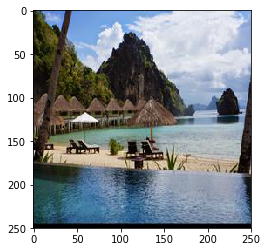

In [17]:
pic = 'GLRC/TESTING/0006aea5b6f4eaaa.jpg'
image = Image.open(pic) 
plt.imshow(image)

In [9]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])

In [10]:
layer_dict

{'add_1': <keras.layers.merge.Add at 0x1c22c901470>,
 'add_2': <keras.layers.merge.Add at 0x1c230afef98>,
 'add_3': <keras.layers.merge.Add at 0x1c2386a7518>,
 'add_4': <keras.layers.merge.Add at 0x1c229553128>,
 'add_5': <keras.layers.merge.Add at 0x1c2388892e8>,
 'add_6': <keras.layers.merge.Add at 0x1c2385f9630>,
 'add_7': <keras.layers.merge.Add at 0x1c238a904a8>,
 'batch_normalization_1': <keras.layers.normalization.BatchNormalization at 0x1c21c474fd0>,
 'batch_normalization_10': <keras.layers.normalization.BatchNormalization at 0x1c2386668d0>,
 'batch_normalization_11': <keras.layers.normalization.BatchNormalization at 0x1c238614470>,
 'batch_normalization_12': <keras.layers.normalization.BatchNormalization at 0x1c2386a7390>,
 'batch_normalization_13': <keras.layers.normalization.BatchNormalization at 0x1c22c9716d8>,
 'batch_normalization_14': <keras.layers.normalization.BatchNormalization at 0x1c22c94a550>,
 'batch_normalization_15': <keras.layers.normalization.BatchNormalizatio

Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed t

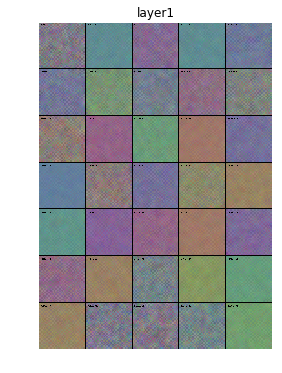

In [45]:
from vis.utils import utils
from keras import activations
from vis.visualization import get_num_filters
from vis.visualization import visualize_activation

# The name of the layer we want to visualize
# You can see this in the model definition.
layer_name = 'layer1'
layer_idx = utils.find_layer_idx(model, layer_name)

# Visualize all filters in this layer.
filters = np.arange(get_num_filters(model.layers[layer_idx]))

# Generate input image for each filter.
vis_images = []
for idx in filters:
    img = visualize_activation(model, layer_idx, filter_indices=idx)
    
    # Utility to overlay text on image.
    img = utils.draw_text(img, 'Filter {}'.format(idx))    
    vis_images.append(img)

# Generate stitched image palette with 8 cols.
stitched = utils.stitch_images(vis_images, cols=5)    
plt.axis('off')
plt.imshow(stitched)
plt.title(layer_name)
plt.show()

Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed t

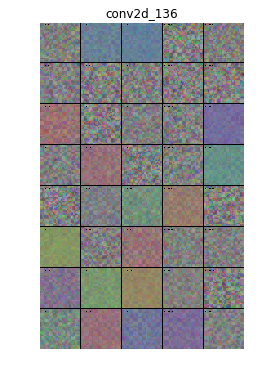

In [44]:
layer_name = 'conv2d_136'
layer_idx = utils.find_layer_idx(model, layer_name)

# Visualize all filters in this layer.
filters = np.arange(get_num_filters(model.layers[layer_idx]))

# Generate input image for each filter.
vis_images = []
for idx in filters:
    img = visualize_activation(model, layer_idx, filter_indices=idx)
    
    # Utility to overlay text on image.
    img = utils.draw_text(img, 'Filter {}'.format(idx))    
    vis_images.append(img)

# Generate stitched image palette with 8 cols.
stitched = utils.stitch_images(vis_images, cols=5)    
plt.axis('off')
plt.imshow(stitched)
plt.title(layer_name)
plt.show()

Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default


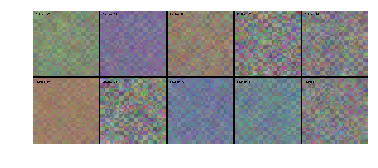

Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default


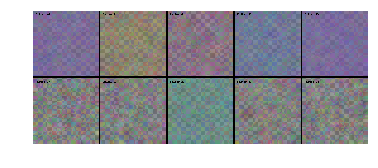

Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default


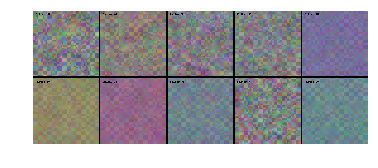

Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default


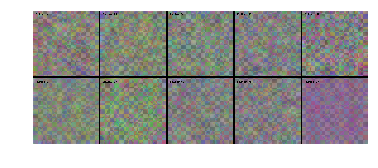

In [15]:
selected_indices = []
for layer_name in ['conv2d_2', 'conv2d_8', 'conv2d_24', 'conv2d_60']:
    layer_idx = utils.find_layer_idx(model, layer_name)

    # Visualize all filters in this layer.
    filters = np.random.permutation(get_num_filters(model.layers[layer_idx]))[:10]
    selected_indices.append(filters)

    # Generate input image for each filter.
    vis_images = []
    for idx in filters:
        img = visualize_activation(model, layer_idx, filter_indices=idx)

        # Utility to overlay text on image.
        img = utils.draw_text(img, 'Filter {}'.format(idx))    
        vis_images.append(img)

    # Generate stitched image palette with 5 cols so we get 2 rows.
    stitched = utils.stitch_images(vis_images, cols=5)    
    plt.figure()
    plt.axis('off')
    plt.imshow(stitched)
    plt.show()